### Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [283]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [293]:
df=pd.read_json('logins.json')

In [285]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [294]:
import numpy as np
df['login']=np.ones(df.shape[0], dtype=int)
df=df.set_index('login_time').sort_index()

In [327]:
# df should have timestamp as its index and index is sorted
# timestamp should be in form: Y-M-D H-M-S
def Bints(df, timecol, interval, cycles):
    df_binned=df.resample(interval).sum()
    df_binned=df_binned.reset_index()
    for cycle in cycles:
        if cycle=='day':
            df_binned['time of day']=df_binned[timecol].apply(lambda t:str(t).split(' ')[1][:5])
        elif cycle=='week':
            df_binned['day of week']=df_binned[timecol].dt.weekday_name
        elif cycle=='month':
            df_binned['day']=df_binned[timecol].apply(lambda ts:ts.day)
        elif cycle=='year':
            df_binned['year']=df_binned[timecol].apply(lambda ts:ts.month)
    
    return (df_binned)

def Plot_bints(df_binned, val, groupby, errorbar):
    fig,ax=plt.subplots()
    agg_df=df_binned.groupby(groupby).agg('mean')
    agg_df.plot(ax=ax)
    if errorbar==True:
        ax.errorbar(agg_df.index, agg_df[val],yerr=df_binned.groupby(groupby).agg('std')[val], fmt='-o')


In [319]:
df_binned=Bints(df, 'login_time', '15T', ['day'])

In [325]:
agg_df=df_binned.groupby('time of day').agg('mean')

In [326]:
agg_df.login

time of day
00:00    14.107843
00:15    15.166667
00:30    14.950980
00:45    14.529412
01:00    15.186275
01:15    15.666667
01:30    16.401961
01:45    14.676471
02:00    14.940594
02:15    14.960784
02:30    14.148515
02:45    13.360000
03:00    12.500000
03:15    12.764706
03:30    11.857143
03:45    10.920000
04:00    11.551020
04:15    11.877551
04:30    13.340000
04:45    14.181818
05:00    11.969388
05:15     8.651685
05:30     6.566265
05:45     5.193182
06:00     4.855263
06:15     4.102564
06:30     3.455882
06:45     2.708861
07:00     2.607143
07:15     2.632184
           ...    
16:30     7.000000
16:45     7.000000
17:00     6.306931
17:15     6.181818
17:30     6.571429
17:45     7.123711
18:00     7.040404
18:15     6.831683
18:30     7.594059
18:45     8.098039
19:00     7.757576
19:15     7.440000
19:30     8.680412
19:45     8.810000
20:00     8.490000
20:15     9.509804
20:30    10.480392
20:45    11.911765
21:00    12.274510
21:15    12.990196
21:30    14.772277


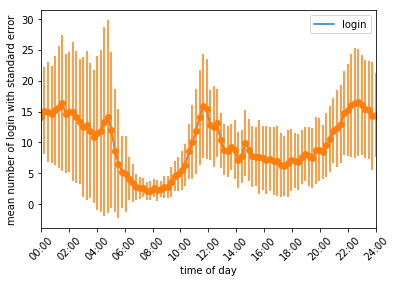

In [329]:
Plot_bints(df_binned, 'login', 'time of day', True)
ticklabels=['00:00', '02:00', '04:00', '06:00', '08:00', '10:00',
       '12:00', '14:00', '16:00', '18:00', '20:00', '22:00', '24:00']
locs, ticks=plt.xticks()
#ax.set_xticks(np.linspace(min(locs), max(locs), 13))
plt.xticks(np.linspace(min(locs), max(locs), 13), ticklabels, rotation=45)
plt.ylabel('mean number of login with standard error')
plt.show()

### Daily cycle pattern

It shows that the within a day a user activity tends to be relativley high in early morning (4-6am), around noon (12pm) or late night (11pm), but lowest during morning (6-10am). This could be because that users mostly go to work during morning while stay home (11pm-4am) or take a rest at noon. However, there is a considerable variation in the extent of activity during morning 4-6am or late night (11pm) and a moderate degree of variation during noon. These could be due to the fluctuation of the user's sleeping schedule and activity around noon. The intensity of activity during morning (6-10am) is consistently low among the users and different months, as indicated by the short error bars. This suggests that morning is usually occupied with work and the schedule during this time is most rigeous. 

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The metric I would choose is normalized difference in daily time (NDDT) spent in two cities, which is the absolute difference in the daily time a driver spends in two cities adjusted by the total time a driver spent in two cities. For example, if a driver spends t1 time in Gotham and t2 time in Metropolis, then this metric would be abs(t1-t2)/(t1+t2).

The reason that t1-t2 is normalized is the absolute difference in t1 and t2 does not fully reflect how much driver is inclined to stay in one city than the other: if overall a driver spends little time driving on a certain day, then t1 and t2 would be both small. In this situation, even when t1 or t2 is zero, their difference would still be small, which may wrongly suggest that the driver has similar intention of serving both cities. 

This metric would always fall in the range 0-1. When one of t1 or t2 is zero, NDDT=1, indicating that the corresponding driver stay exclusively in one city. When t1=t2, NDDT=0, indicating that the corresponding driver has equal intention of serve in both cities. 

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a. how you will implement the experiment b. what statistical test(s) you will conduct to verify the significance of the observation c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

I would first randomly pick a group of drivers from Gotham and a group of drivers from Metropolis, which I name Gotham_A, and Metropolis_A. Then match each of them with another driver from the same city who also has a similar working schedule as the drive he or she is to be matched with. I call the group matched to Gotham_A as Gotham_B, and Metropolis_B for group that is matched to Metropolis_A. Groups Gotham_A and Metropolis_A will be the test groups who will recieve the toll reimbursement, while groups Gotham_B and Metropolis_B will be the control groups. 

Their paird group would look like,

Gotham_A  Gotham_B 
driver A1 driver B1
driver A2 driver B2
...


Metropolis_A Metropolis_B
driver A1    driver B1
driver A2    driver B2
...

Then I pick at least a week for the experiment, during which there should not be big events or holidays which may affect a driver's decision to serve in either city. As mentioned, I will offer Gotham_A and Metropolis_A drivers toll reimbursement for a week (Mon-Sun), but no reimbursement for the other two groups. During this period, I would keep track of the time of each toll, direction of each toll (from one city to the other), and working hours (if possible) of each driver. I would use these information to calculate each driver's NDDT. 

For example, driver A has four tolls on Monday: first from Gotham to Metropolis at 10am, second from Metropolis to Gotham at 12pm, third from from Gotham to Metropolis at 2pm and fourth back to Gotham at 4pm. I also know that on Monday driver A starts working at 8am and ends working at 6pm. Then we can see that the period that driver A spends in Gotham is 8-10am, 12-2pm, and 4pm-6pm while the periods that he spends in Metropolis are 10am-12pm, 2-4pm. If we denote the total time driver A spends in Gotham on Monday as t1 and that in Metropolis as t2, then t1=(10-8)+14-12+18-16=6hours and t2=(12-10)+(4-2)=4hours. Then driver A's NDDT on Monday is abs(t1-t2)/(t1+t2)=abs(6-4)/(6+4)=0.2. 

Then I would calculate the NDDT for each driver, and calculate the pairwise difference for each day:

Pair  Gotham_A  Gotham_B    NDDT_A   NDDT_B     diff         day 
1     driver A1 driver B1     V1A1     V1B1     V1A1-V1B1    Mon
                              V1A2     V1B2     V1A2-V1B2    Tue
...
1     driver A2 driver B2     V2A1     V2B1     V2A1-V2B1    Mon
                              V2A2     V2B2     V2A2-V2B2    Tue
...
  
  
Pair  Metropolis_A  Metropolis_B    NDDT_A   NDDT_B     diff       day 
1     driver A1     driver B1       V1A1     V1B1     V1A1-V1B1    Mon
                                    V1A2     V1B2     V1A2-V1B2    Tue
...
1     driver A2      driver B2      V2A1     V2B1     V2A1-V2B1    Mon
                                    V2A2     V2B2     V2A2-V2B2    Tue
...

Then I will do paired fraction t test to test the null hypothesis that the mean of diff variable is zero, which means that there is no difference between test and control, or no effect of roll reimbursement on driver's intention of exclusively staying in two cities. 

The hypothesis tested will be following: 

H0_1: the mean of pairwise difference in NDDT for drivers from Gotham during weekdays is zero: mean(diff|city=Gotham, day=Mon|Tue|Wed|Thu|Fri)=0
H0_2: the mean of pairwise difference in NDDT for drivers from Gotham during weekends is zero: mean(diff|city=Gotham, day=Sat|Sun)=0

H0_3: the mean of pairwise difference in NDDT for drivers from Metropolis during weekdays is zero: mean(diff|city=Metropolis, day=Mon|Tue|Wed|Thu|Fri)=0
H0_4: the mean of pairwise difference in NDDT for drivers from Metropolis during weekends is zero: mean(diff|city=Metropolis, day=Sat|Sun)=0

I will repeat the above test separately for Gotham, Metropolis and for both of them by pooling the diff values. The likely results are as follow,

i. All null hypothesis are rejected, and all means of pairwise diff in each subgroup are negative. This indicates that toll reimbursement has significant impact on drivers from both cities and on both weekdays and weekends; 

ii. H0_1 and H0_2  are rejected but H0_3 and H0_4 are not, and means of pairwise diff in first two subgroups are negative. This indicates that toll reimbursement has significant impact on drivers from Gotham on both weekdays and weekends but no impact on drivers from Metropolis; 

iii. H0_1 and H0_2  are not rejected but H0_3 and H0_4 are rejected, and means of pairwise diff in drivers from Metropolis are negative. This indicates that toll reimbursement has significant impact on drivers from Metropolis on both weekdays and weekends but no impact on drivers from Gotham; 

iv. H0_1 and H0_3 are rejected. This indicates that toll reimbursement only works during weekdays. 

v. H0_2 and H0_4 are rejected. This indicates that toll reimbursement only works during weekends. 

vi. Except the above situations and one (or two) of the hypothesis is rejected while other three (or two) are not. This indicates that whether toll reimbursement has impact on driver's intention to serve both cities depends on both the city and the day of the week. 

If situation i happens, then city operations team may more confidently use the toll reimbursement to increase drivers' intention of serving both cities. If situation ii or iii occurs, then city operations team should look into the causes that toll reimbursement only work for one city. If situation iv or v occurs then city operations team may consider toll reimbursement during certain days of week. If situation vi occurs then city operations team should look into the combinations of city and day of week that toll reimbursement has a significant impact. 


### Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).


Data description
● city: city this user signed up in
● phone: primary device for this user
● signup_date: date of account registration; in the form ‘YYYY MM DD’
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
● avg_rating_by_driver: the rider’s average rating over all of their trips
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
● surge_pct: the percent of trips taken with surge multiplier > 1
● avg_surge: The average surge multiplier over all of this user’s trips
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
● weekday_pct: the percent of the user’s trips occurring during a weekday

In [1]:
import pandas as pd

In [2]:
import json

with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df=pd.DataFrame(data)

In [3]:
df.head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


# Data cleaning

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [5]:
for c in df.columns:
    print (c)
    print (df[c].describe())

avg_dist
count    50000.000000
mean         5.796827
std          5.707357
min          0.000000
25%          2.420000
50%          3.880000
75%          6.940000
max        160.960000
Name: avg_dist, dtype: float64
avg_rating_by_driver
count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64
avg_rating_of_driver
count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64
avg_surge
count    50000.000000
mean         1.074764
std          0.222336
min          1.000000
25%          1.000000
50%          1.000000
75%          1.050000
max          8.000000
Name: avg_surge, dtype: float64
city
count          50000
unique             3
top       Winterfell
freq           233

It looks like that columns with numerical values are valid given their definition and units. However, there are several columns with missing values, such as avg_rating_by_driver, avg_rating_of_driver and phone. I will take a look at these three columns and replace the missing values with null values if necessary.

In [6]:
df['avg_rating_by_driver'].unique()

array([ 5. ,  4.9,  4. ,  3. ,  4.8,  4.7,  4.5,  4.2,  nan,  4.4,  4.6,
        3.7,  4.3,  3.5,  2. ,  3.8,  2.5,  4.1,  3.9,  1. ,  3.3,  3.4,
        3.6,  3.2,  2.3,  2.8,  1.5,  2.7])

In [7]:
df['avg_rating_of_driver'].unique()

array([ 4.7,  5. ,  4.3,  4.6,  4.4,  3.5,  nan,  4.5,  4. ,  3.9,  4.9,
        4.8,  2.5,  3.7,  1. ,  4.1,  4.2,  3. ,  3.8,  2. ,  2.7,  3.3,
        2.8,  3.6,  3.4,  3.2,  2.6,  3.1,  2.9,  1.7,  1.8,  1.5,  2.3,
        1.9,  2.1,  2.4,  1.6,  2.2])

In [8]:
df['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

In [9]:
import numpy as np
df['phone'].replace("None", np.nan, inplace=True)

Then I check the columns with strings to see whether the format is consistent across the column. For example, city name may follow "CityName" format. 

In [10]:
df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

It shows that there are three truly different cities here, so there is no need to further clean this column

Then I check the type of column with time information: signup_date and last_trip_date

In [11]:
print (type(df.signup_date[0]))
print (type(df.last_trip_date[0]))

<class 'str'>
<class 'str'>


It shows both are strings, but to better calculate the difference between these two dates, I need to transform both to timestamps

In [12]:
df.signup_date=df.signup_date.apply(pd.to_datetime)
df.last_trip_date=df.last_trip_date.apply(pd.to_datetime)

In [13]:
print (type(df.signup_date[0]))
print (type(df.last_trip_date[0]))

<class 'pandas._libs.tslib.Timestamp'>
<class 'pandas._libs.tslib.Timestamp'>


in addition, last_trip_date should not be earlier than signup_date, so I also check their difference

In [14]:
sum((df.last_trip_date<=df.signup_date)<0)

0

all last trip dates are later than sign up dates

### Exploratory data analysis to understand the difference in each feature between the retained users and non retained users

In [15]:
# create a column that indicate the retention: still active within the preceding 30 days

df['retained']=(df.last_trip_date.max()-df.last_trip_date).apply(lambda ts:(ts.days)<30)

In [16]:
print ('{} percent of users are retained'.format(100*float(sum(df['retained']))/len(df['retained'])))

36.62 percent of users are retained


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

def Compare_value_2groups(groupby, col, data):
    sns.barplot(x=groupby, y=col, data=data)
    p_value=scipy.stats.ttest_ind(df[df[groupby]][col].dropna(), df[~df[groupby]][col].dropna(), equal_var=False).pvalue
    print ('p-value of null hypothesis is {}'.format(p_value))
    plt.show()

def Compare_count_2groups(groupby, col, data):
    plt.subplot(1,2,1)
    plt.title(groupby+'True')
    sns.barplot(x=df[df[groupby]][col].value_counts().index, y=[float(v)/sum(df[df[groupby]][col].value_counts()) for v in df[df[groupby]][col].value_counts()])
    plt.xlabel(col)
    plt.ylim(0,1)
    plt.subplot(1,2,2)
    plt.title(groupby+'False')
    sns.barplot(x=df[~df[groupby]][col].value_counts().index, y=[float(v)/sum(df[~df[groupby]][col].value_counts()) for v in df[~df[groupby]][col].value_counts()])
    plt.xlabel(col)
    plt.ylim(0,1)
    p_value=scipy.stats.chisquare(f_obs=df[df[groupby]][col].value_counts(), f_exp=df[~df[groupby]][col].value_counts()).pvalue
    print ('p-value of null hypothesis is {}'.format(p_value))
    plt.show()


p-value of null hypothesis is 1.1802695154255914e-105


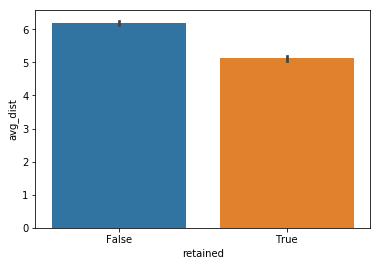

p-value of null hypothesis is 1.6677369496544986e-10


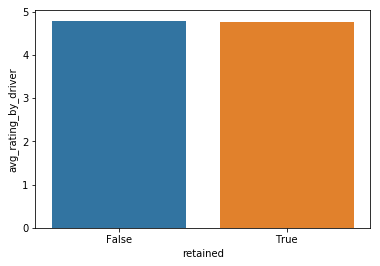

p-value of null hypothesis is 0.020793983160803824


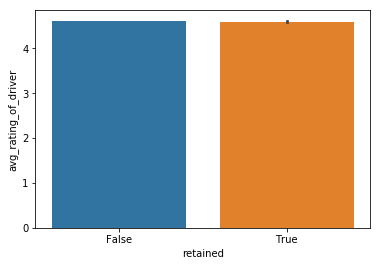

p-value of null hypothesis is 0.37405090621360204


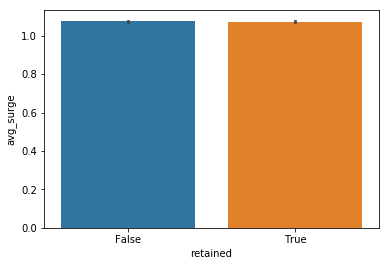

p-value of null hypothesis is 0.00928959090240409


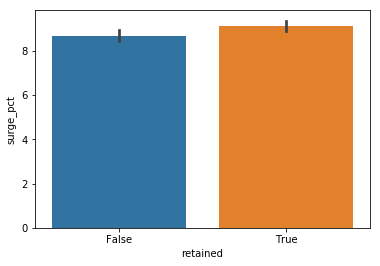

p-value of null hypothesis is 0.0


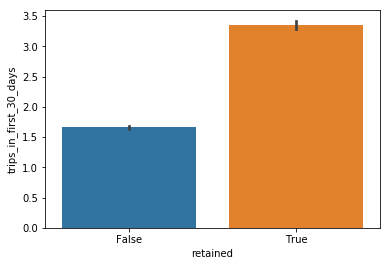

p-value of null hypothesis is 1.0836060942756592e-10


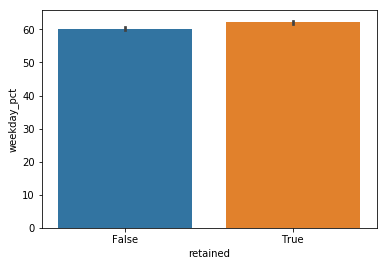

In [18]:
for var in ["avg_dist", "avg_rating_by_driver", 
            "avg_rating_of_driver", "avg_surge",
            "surge_pct", "trips_in_first_30_days",
            "weekday_pct"]:
    Compare_value_2groups("retained", var, df)


In [19]:
# transform categorical data to 

p-value of null hypothesis is 0.0


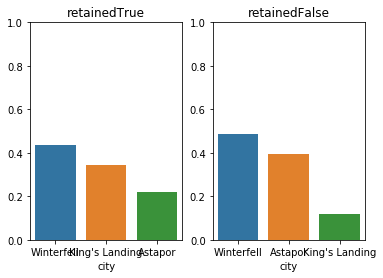

p-value of null hypothesis is 0.0


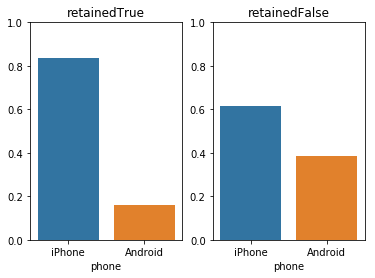

p-value of null hypothesis is 0.0


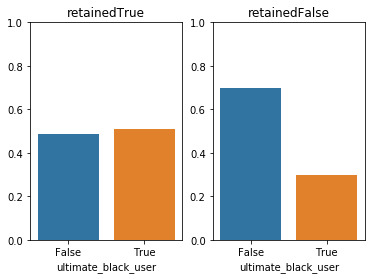

In [20]:
Compare_count_2groups("retained", "city", df)
Compare_count_2groups("retained", "phone", df)
Compare_count_2groups("retained", "ultimate_black_user", df)

### Some observations after the exploratory data analysis
Given that I am looking at the difference in distribution of 10 features between the retained group and non-retained group, I need Boffaroni correction to take into account the multiple tests. That says, I need to divide the critical value of significance 0.05 by the number of tests I did, 10, which gives rise to 0.005. That says, only tests result with p value lower than 0.005 are counted as statistical significant. It is shown that tests on features except "avg_rating_of_driver", "surge_pct" and  "avg_surge", have p value lower than 0.005, which means that all these features have statistically significant different distribution between the retained users and non-retained users. 

The results show that compared to non-retained users, retained users tend to have lower avg_dist,  lower avg_rating_by_driver, lower avg_surge, more trips_in_first_30_days, more weekday_pct, less likely from Winderfell and Astapo but more likely from King's landing, more likely using iphone than android, and more likely have become ultimate black users. 

I found that 7 features have significantly different distribution between the retained users and left users. However, whether there exists multicollinearity among these features? This is an important question because multicollinearity can affect a machine learning algorithm such as regression or tree-based model, e.g. random forest model. 

In [101]:
# features: list of variables names between which correlation is calculated
def ANOVA(groupby, col, df):
    data=df[[groupby, col]].dropna()
    n=len(data[groupby].unique())
    N=data.shape[0]
    SSwithin = sum(data.groupby(groupby).var()[col]*data[groupby].value_counts())
    fw=N - n
    SSbetween = sum(((data.groupby(groupby).mean()[col]-data[col].mean())**2)*data[groupby].value_counts())
    fb = n - 1
    MSbetween = SSbetween/fb
    MSwithin = SSwithin/fw
    F = MSbetween/MSwithin
    p = scipy.stats.f.sf(F, fb, fw)
    return (p)

def Pearsonr(col1,col2,df):
    data=df[[col1,col2]].dropna()
    n=data.shape[0]
    sum_cov=((data[col1]-data[col1].mean())*(data[col2]-data[col2].mean())).sum()
    std1=(((data[col1]-data[col1].mean())**2).sum()/(n-1))**0.5
    std2=(((data[col2]-data[col2].mean())**2).sum()/(n-1))**0.5
    r=(1/(n-1))*sum_cov/(std1*std2)
    t=r*(n-2)**(0.5)/(1-r**2)**(0.5)
    p_value=scipy.stats.t.sf(t, n-1)
    return (r,p_value)

def Correlation(features, df):
    category=["category", "bool", 'object']
    continuous=['int64', 'float64', 'int32', 'float32']
    if features[0]==features[1]:
        p_value=None
    else:
        if df[features[0]].dtype.name in category and df[features[1]].dtype.name in category:
            table=pd.crosstab(df[features[0]], df[features[1]]).values
            p_value=scipy.stats.chi2_contingency(table)[1]
        elif df[features[0]].dtype.name in category and df[features[1]].dtype.name in continuous:
            p_value=ANOVA(features[0], features[1], df)
        elif df[features[0]].dtype.name in continuous and df[features[1]].dtype.name in category:
            p_value=ANOVA(features[1], features[0], df)
        elif df[features[0]].dtype.name in continuous and df[features[1]].dtype.name in continuous:
            r,p_value=Pearsonr(features[0], features[1],df)
    return (p_value)

In [59]:
import numpy as np
from itertools import combinations

#print (df.groupby("retained").var()["avg_dist"])
#print (df["retained"].value_counts())
#print (df.groupby("retained").var()["avg_dist"]*df["retained"].value_counts())
#df["city"].dtype.name
features=df.drop(['retained','signup_date', 'last_trip_date'], axis=1).columns
correlation_matrix=np.empty([len(features), len(features)])
corr_df=pd.DataFrame(correlation_matrix)
corr_df.index=features
corr_df.columns=features
for tup in combinations(features, 2):
    p_value=Correlation([tup[0],tup[1]], df)
    print (round(p_value, 4))
    corr_df.loc[tup[0]][tup[1]]=corr_df.loc[tup[1]][tup[0]]=round(p_value, 4)

0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.009
0.0
0.0395
0.0
1.0
0.0371
0.0
1.0
0.0
0.0
0.7876
0.9896
0.6696
0.0014
0.0
0.031
0.0
0.6597
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0139
0.0
0.0
0.0571
0.1005
0.0
1.0
0.0
0.0
0.0


In [60]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

def Color_cv(val, critical_val):
    if val !=None:
        color = 'red' if val < critical_val else 'black'
    else:
        color='black'
    return 'color: %s' % color
critical_val=0.05/nCr(len(corr_df.index),2)
s=round(corr_df, 4).style.applymap(lambda x:Color_cv(val=x,critical_val=critical_val))

In [61]:
s

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,0,0,0,1,0,0,1,1,0,0
avg_rating_by_driver,0,0,0,0.009,0,0.0395,0,1,0.0371,0
avg_rating_of_driver,0,0,0,1,0,0,0.7876,0.9896,0.6696,0.0014
avg_surge,1,0.009,1,0,0,0.031,0,0.6597,0,1
city,0,0,0,0,0,0,0,0,0,0
phone,0,0.0395,0,0.031,0,0,0.0139,0,0,0.0571
surge_pct,1,0,0.7876,0,0,0.0139,0,0.1005,0,1
trips_in_first_30_days,1,1,0.9896,0.6597,0,0,0.1005,0,0,0
ultimate_black_user,0,0.0371,0.6696,0,0,0,0,0,0,0
weekday_pct,0,0,0.0014,1,0,0.0571,1,0,0,0


There are many pairs of features with p values below bonferroni correction critical value, which indicate multicollinearity.

# Classfication
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

This is a classification task. Here I use logistic regression and svm. 

First, I preprocess the data for logistic regression: do one-hot encoding on categorical variables.  

In [68]:
df['ultimate_black_user']=df['ultimate_black_user'].astype(int)

In [78]:
df_dummy=pd.get_dummies(df.drop(["retained", "signup_date", "last_trip_date"], axis=1).dropna())

In [79]:
df_dummy.head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,0,1,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0,0,1,1,0


### Given the multicollinearity indicated earlier, I will determine whether it is severe enough to harm the model performance. Therefore, I check the VIF (variance inflated factor)

In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df_dummy.values
for i in range(df_dummy.shape[1]):
    print (df_dummy.columns[i], vif(df_dummy.values, i))

avg_dist 1.05229144858
avg_rating_by_driver 1.03567194749
avg_rating_of_driver 1.02812499417
avg_surge 2.74040702278
surge_pct 2.80586961783
trips_in_first_30_days 1.04758357101
ultimate_black_user 1.03572962733
weekday_pct 1.03942063272
city_Astapor inf
city_King's Landing inf
city_Winterfell inf
phone_Android inf
phone_iPhone inf


C:\anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dummy variables that are created from the same categorical variable have perfect collinearity so they show inf vif. Besides, variables avg_surge and surge_pct show relatively high vif due to their strong correlation. However, avg_surge has not significant correlation with whether a user is retained or not, so I can safely remove this variable. 

In [83]:
df_dummy=df_dummy.drop(["avg_surge"], axis=1)

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df_dummy.values
for i in range(df_dummy.shape[1]):
    print (df_dummy.columns[i], vif(df_dummy.values, i))

avg_dist 1.05228004533
avg_rating_by_driver 1.03565574334
avg_rating_of_driver 1.0273078135
surge_pct 1.05161761011
trips_in_first_30_days 1.04747307937
ultimate_black_user 1.03537305525
weekday_pct 1.03931397005
city_Astapor inf
city_King's Landing inf
city_Winterfell inf
phone_Android inf
phone_iPhone inf


C:\anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


After I removed this variable, all vif are reasonably low (except the dummy variable which are fine). 

In [85]:
df=df.drop(["avg_surge"], axis=1)

As shown earlier, some columns have missing data, so I checked whether data is missing randomly or in a pattern.

In [87]:
for c in df.columns:
    if sum(df[c].isnull())>0:
        df[c+'missing']=df[c].isnull()

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
avg_dist                       50000 non-null float64
avg_rating_by_driver           49799 non-null float64
avg_rating_of_driver           41878 non-null float64
city                           50000 non-null object
last_trip_date                 50000 non-null datetime64[ns]
phone                          49604 non-null object
signup_date                    50000 non-null datetime64[ns]
surge_pct                      50000 non-null float64
trips_in_first_30_days         50000 non-null int64
ultimate_black_user            50000 non-null int32
weekday_pct                    50000 non-null float64
retained                       50000 non-null bool
avg_rating_by_drivermissing    50000 non-null bool
avg_rating_of_drivermissing    50000 non-null bool
phonemissing                   50000 non-null bool
dtypes: bool(4), datetime64[ns](2), float64(5), int32(1), int64(1), object(2)
memory 

Three variables have missing values so three additional columns are added to indicate the row with missing values. A comparison of each feature between rows with missing values and rows with input may shown that whether a column's value is missing at random

In [113]:
def Missing_randomness(missing_ind_col, df):
    p_values=dict()
    for var in df.columns:
        if var !=missing_ind_col:
            p_value=Correlation([missing_ind_col, var], df)
            p_values[var]=p_value
    critical_v=0.05/len(p_values.keys())
    correlated_columns=list()
    for k,v in p_values.items():
        if v<critical_v:
            correlated_columns.append(k)
    return (correlated_columns)

In [114]:
correlated_columns=Missing_randomness("avg_rating_by_drivermissing", df.drop(["avg_rating_of_drivermissing",
                                                           "phonemissing",
                                                            "signup_date",
                                                            "last_trip_date"], axis=1))
print (("columns {} are correlated with "+"avg_rating_by_drivermissing").format(correlated_columns))

correlated_columns=Missing_randomness("avg_rating_of_drivermissing", df.drop(["avg_rating_by_drivermissing",
                                                           "phonemissing",
                                                            "signup_date",
                                                            "last_trip_date"], axis=1))
print (("columns {} are correlated with "+"avg_rating_of_drivermissing").format(correlated_columns))

correlated_columns=Missing_randomness("phonemissing", df.drop(["avg_rating_of_drivermissing",
                                                           "avg_rating_by_drivermissing",
                                                            "signup_date",
                                                            "last_trip_date"], axis=1))
print (("columns {} are correlated with "+"phonemissing").format(correlated_columns))

C:\anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


columns ['surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'retained'] are correlated with avg_rating_by_drivermissing
columns ['avg_dist', 'city', 'phone', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'retained'] are correlated with avg_rating_of_drivermissing
columns ['avg_dist', 'surge_pct', 'ultimate_black_user', 'weekday_pct'] are correlated with phonemissing


It shows that all three variables are not missing completely at random. Missing status is significanlty correlated with multiple features and the outcome variable "retained". One way is to do multiple imputation for the continuous variable and creat a new level for NA values for the categorical variable. 

Given that the amount of non-retained users is almost twice that of retained users, the outcome variable (retained or not) has a skewed distribution. To make sure that training data well generalize to test data, I do stratified sampling to ensure that fraction of retained users is largely same between training data and test data. However, imputation on multiple variables may increase the model complexity and variance. I take a look at the number of missing values for each column and to see that how much data will be lost if we delete each variable or two or three of them. 

In [127]:

f1=float(sum(df["avg_rating_of_drivermissing"]))/df.shape[0]
f2=float(sum(df[(df["avg_rating_of_drivermissing"])]["retained"]))/df.shape[0]
print ("if we delete avg_rating_of_driver, {} data will be lost and {} retained users are among them, representing {} of the missing data".format(f1,f2, f2/f1))

f1=float(sum(df["avg_rating_by_drivermissing"]))/df.shape[0]
f2=float(sum(df[(df["avg_rating_by_drivermissing"])]["retained"]))/df.shape[0]
print ("if we delete avg_rating_by_driver, {} data will be lost and {} retained users are among them, representing {} of the missing data".format(f1,f2, f2/f1))

f1=float(sum(df["phonemissing"]))/df.shape[0]
f2=float(sum(df[(df["phonemissing"])]["retained"]))/df.shape[0]
print ("if we delete phone, {} data will be lost and {} retained users are among them".format(f1,f2))

f1=float(sum(df["avg_rating_by_drivermissing"] | df["avg_rating_of_drivermissing"]))/df.shape[0]
f2=float(sum(df[(df["avg_rating_by_drivermissing"] | df["avg_rating_of_drivermissing"])]["retained"]))/df.shape[0]
print ("if we delete missing data from avg_rating_by_driver and avg_rating_of_driver, {} data will be lost and {} retained users are among them, representing {} of the missing data".format(f1,f2, f2/f1))

f1=float(sum(df["avg_rating_by_drivermissing"] | df["phonemissing"]))/df.shape[0]
f2=float(sum(df[(df["avg_rating_by_drivermissing"] | df["phonemissing"])]["retained"]))/df.shape[0]
print ("if we delete missing data from avg_rating_by_driver and phone, {} data will be lost and {} retained users are among them, representing {} of the missing data".format(f1,f2, f2/f1))

if we delete avg_rating_of_driver, 0.16244 data will be lost and 0.03136 retained users are among them, representing 0.1930558975621768 of the missing data
if we delete avg_rating_by_driver, 0.00402 data will be lost and 0.00068 retained users are among them, representing 0.1691542288557214 of the missing data
if we delete phone, 0.00792 data will be lost and 0.0026 retained users are among them
if we delete missing data from avg_rating_by_driver and avg_rating_of_driver, 0.16512 data will be lost and 0.03164 retained users are among them, representing 0.1916182170542636 of the missing data
if we delete missing data from avg_rating_by_driver and phone, 0.01188 data will be lost and 0.00328 retained users are among them, representing 0.2760942760942761 of the missing data


Overall, it shows that the fraction of retained users among the users with missing data is lower than users with complete data. This suggest that data are more likely accessed among retained users. This indicates that data with complete records do not represent the whole user population. Rather it is skewed towards retained users, or retained users more likely provide complete data. This may harm the generalizability of the model. However, how much this impact is is unclear. In addition, the column with the largest amount of missing value is avg_rating_of_driver, which has no significant correlation with a user being retained or not. Therefore, I temporarily remove this column and drop the na values from the other two columns, which result in 1.1% lost of data.

In [130]:
df=df.drop(["avg_rating_by_drivermissing", "phonemissing", "avg_rating_of_drivermissing", "avg_rating_of_driver"], axis=1)

In [213]:
df_nonull=pd.get_dummies(df.drop(["signup_date","last_trip_date"], axis=1).dropna())

In [214]:
from sklearn.model_selection import train_test_split
X_rt=df_nonull[df_nonull["retained"]].drop(["retained"], axis=1).values
y_rt=df_nonull[df_nonull["retained"]].retained.astype(int).values
X_nrt=df_nonull[~df_nonull["retained"]].drop(["retained"], axis=1).values
y_nrt=df_nonull[~df_nonull["retained"]].retained.astype(int).values

X_train_rt, X_test_rt, y_train_rt, y_test_rt = train_test_split(X_rt, y_rt, test_size=0.33, random_state=42)
X_train_nrt, X_test_nrt, y_train_nrt, y_test_nrt = train_test_split(X_nrt, y_nrt, test_size=0.33, random_state=42)

In [215]:
X_train=np.row_stack([X_train_rt, X_train_nrt])
y_train=np.concatenate([y_train_rt, y_train_nrt])

X_test=np.row_stack([X_test_rt, X_test_nrt])
y_test=np.concatenate([y_test_rt, y_test_nrt])

In [216]:
#rescale the columns (except dummy variables) to have mean at zero and variance around 1
def Rescale(X):
    data=pd.DataFrame(X)
    for c in data.columns:
        if set(data[c]) !=set([0,1]):
            data[c]=(data[c]-data[c].mean())/data[c].std()
    return (data.values)

In [218]:
X_train=Rescale(X_train)
X_test=Rescale(X_test)

In [278]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score

def Gridsearchcv_report(data, classifier, param_grid, scores, refit_score):
    """grid search for a classifier that returns the searched results"""
    X_train, X_test, y_train, y_test=data
    stk=StratifiedKFold(n_splits=10)
    GCV= GridSearchCV(classifier, param_grid, scoring=scores, refit=refit_score,cv=stk, return_train_score=True, n_jobs=-1)
    GCV.fit(X_train, y_train)
    
    y_pred = GCV.predict(X_test)
    y_score=GCV.decision_function(X_test)
    print ("\n\nWhen optimized for {} on the training data:".format(refit_score))
    print ("tuned parameter are {}".format(GCV.best_params_))
    print ("The final {} is {}".format(refit_score, GCV.best_score_))
    print('\nConfusion matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['predicted pos', 'predicted neg'], index=['true pos', 'true neg']))
    f1=f1_score(y_test, y_pred)
    precision=precision_score(y_test, y_pred)
    recall=recall_score(y_test, y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    AUC=auc(fpr, tpr)
    
    print ('\nmetrics on the test test are:\nprecision={}, recall={}, f1_meansure={}, AUC={}'.format(precision, recall, f1, AUC))
    return (GCV)

#def Plot_classifier(ROC=True, confusion_matrix=True):
    

In [282]:
LR=LogisticRegression()
param_grid = [{"C": np.linspace(0.001, 1000, 30),
               "intercept_scaling": [1, 3, 5, 10, 20, 50, 100, 200]}]

scores = ['roc_auc','precision_macro', 'recall_macro', 'f1_macro']
data=(X_train, X_test, y_train, y_test)
GCVs=list()
for score in scores:
    GCV=Gridsearchcv_report(data, LR, param_grid, scores, refit_score=score)
    GCVs.append(GCV)



When optimized for roc_auc on the test data:
tuned parameter are {'C': 103.44917241379312, 'intercept_scaling': 200}
The final roc_auc is 0.7663480636015173

Confusion matrix:
          predicted pos  predicted neg
true pos           8902           1414
true neg           3077           2912

metrics on the test test are:
precision=0.6731391585760518, recall=0.4862247453665053, f1_meansure=0.5646146388754241, AUC=0.674578057057041


When optimized for precision_macro on the test data:
tuned parameter are {'C': 0.001, 'intercept_scaling': 100}
The final precision_macro is 0.7197388158957526

Confusion matrix:
          predicted pos  predicted neg
true pos           9452            864
true neg           3749           2240

metrics on the test test are:
precision=0.7216494845360825, recall=0.37401903489731175, f1_meansure=0.49268668206312555, AUC=0.6451328210547047


When optimized for recall_macro on the test data:
tuned parameter are {'C': 34.483724137931034, 'intercept_scaling': 2

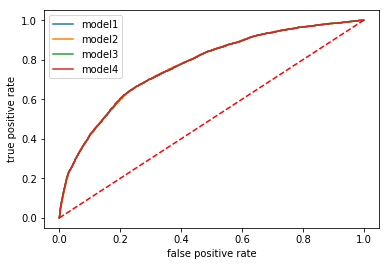

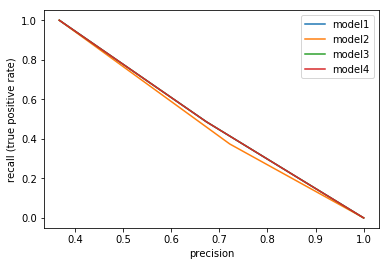

In [314]:
fig=plt.figure()
for i in range(4):
    GCV=GCVs[i]
    y_score = GCV.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label='model'+str(i+1))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
plt.plot([0,1],[0,1], color='r', linestyle='--')
plt.legend()
plt.show()

fig=plt.figure()
for i in range(4):
    GCV=GCVs[i]
    y_pred = GCV.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=1)
    plt.plot(precision, recall, label='model'+str(i+1))
    plt.xlabel('precision')
    plt.ylabel('recall (true positive rate)')
plt.legend()
plt.show()

It shows that when the model is optimized for auc, recall or f1_measure on training data (model 1, 3 and 4), the results are the same. This is because, auc, and f1_measusre all include recall as part of its measure. When recall is the bottleneck of optimization, the tuning process will try to increase recall as much as possible which largely determine the direction that parameters are tuned. In contrast, when optimized on precision (model 2), the tuned model gives a slightly worse recall, or high false negative rate. 

Model 1,3 and 4 are considered slightly better than model 2. However, the precision-recall curve shows that overall logistic regression does not have satisfying performance. 

Therefore, I choose to examine another classifier: SVM. However, before moving one, I take a look at the coefficients estimated by logistic regression. 

# Insights

Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

In [326]:
import seaborn as sns

def Coefficient_plot(coef, names):
    coef_db = pd.DataFrame(np.round_(coef, decimals=3), columns = ["coefficients"])
    coef_db['features']=names     
    # remove the zero coefficients
    coef_db = coef_db[coef_db['coefficients'] != 0]
    # sort the values from high to low
    coef_db = coef_db.sort_values(by = 'coefficients', ascending = False)
    plt.figure(figsize=(20,40))
    ax = sns.barplot(x = 'coefficients', y= coef_db['features'] , data=coef_db)
    ax.set(xlabel='Penalized Regression Coefficients')
    sns.set(font_scale = 10)
    plt.show()

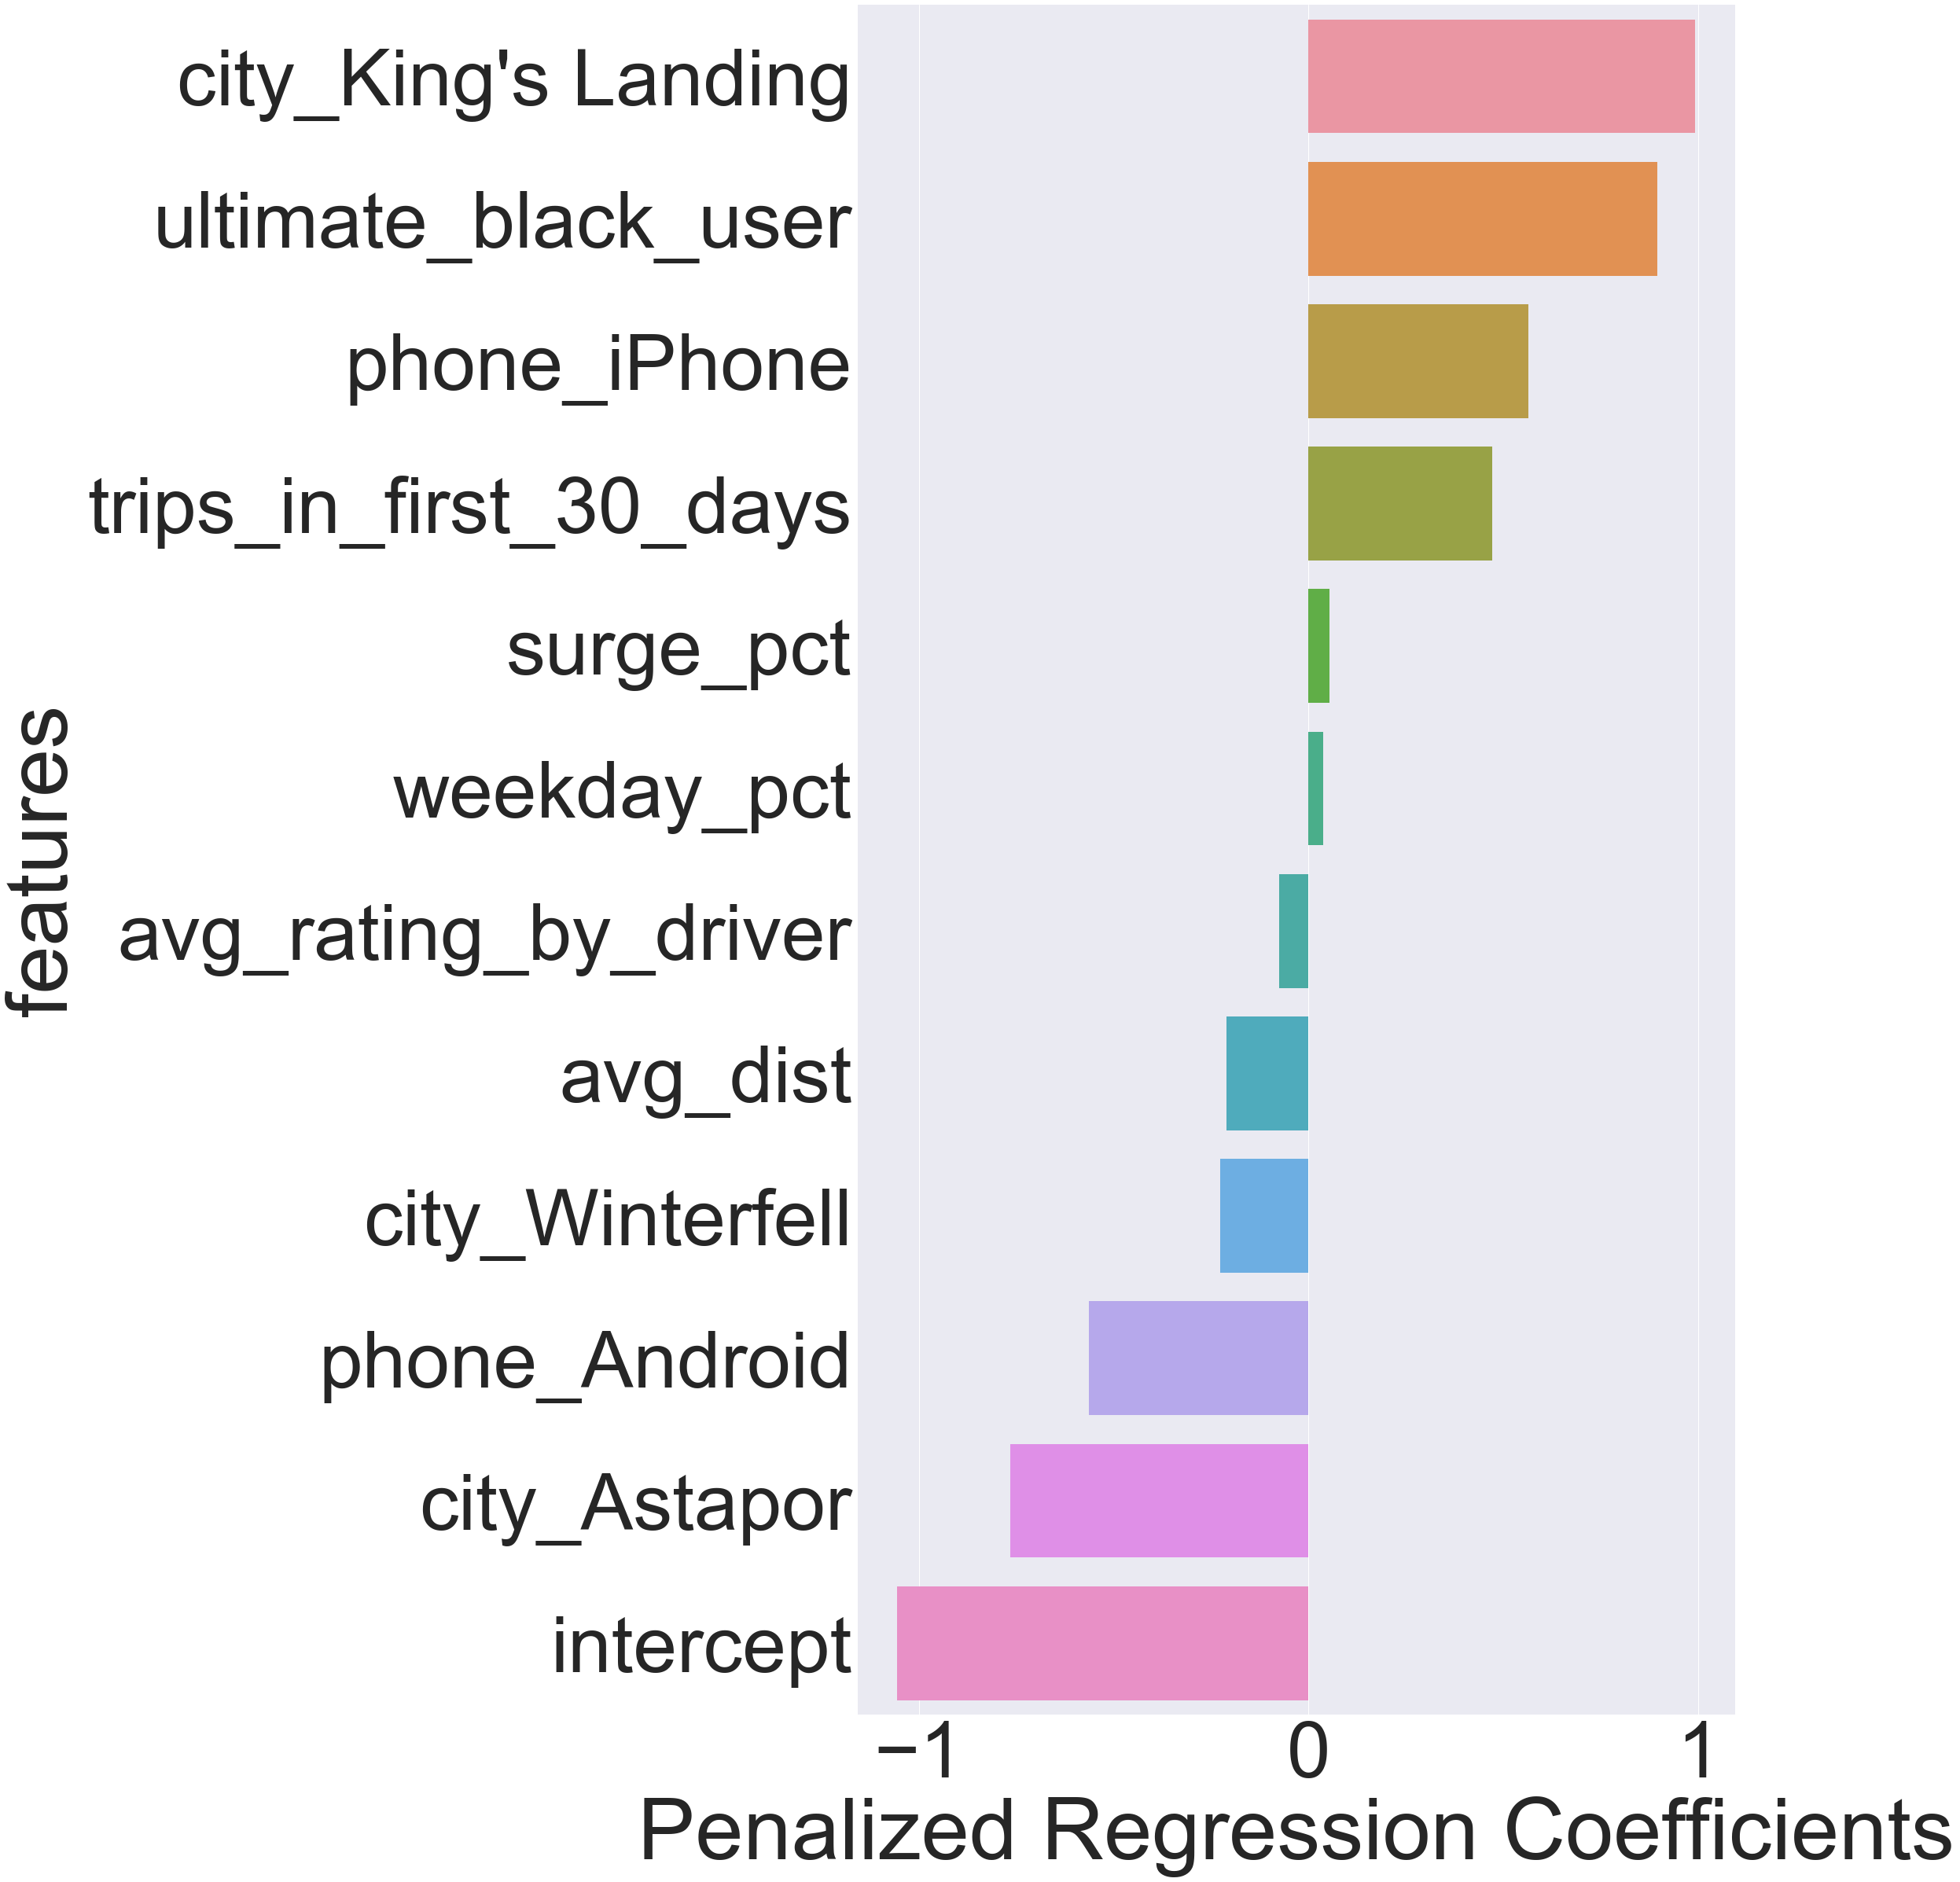

In [333]:
coef=np.concatenate([GCVs[3].best_estimator_.intercept_, GCVs[3].best_estimator_.coef_[0]])
names=np.concatenate([['intercept'], df_nonull.drop(['retained'], axis=1).columns])
Coefficient_plot(coef, names)

# Some observations:
### The coefficients show how each feature affect the probability that a user will be adopted or not:
- Being from King's landing increases the probability that a user is retained; By contrast, being form Astapor or Winterfell reduces this probaiblity; 
- Using iphone increases the probability that a user is retained while using Android reduces such probability
- Users who traveled more trips within the first 30 days are more likely to be a retained user later
- Users who turned ultimate black user are also more likely to be retained later

### The insights from the results:
To increase the probability of users being retained, the company may work in following directions:
- Understanding the difference in the three cities and the likely reasons that users in king's landing are more likely to be retained than users from other two cities; 
- Putting more efforts into attracting users through iphone; 
- Monitoring the number of trips a user has within the first 30 days after creating an account and putting efforts to transform the users who travel more within the first 30 days to be ultimate black users; 